In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from sklearn.model_selection import train_test_split

# Get data
Pandas is used to get the data from the project directory.
The data is a .csv file, that has been created by book texts and prepared to be listed in the file word-by-word.

In [18]:
df = pd.read_csv('dataset.csv')
df = df.sample(frac=1.0, random_state=42)
df.head()

,Word,Language
72269,gründler hufvudstupa rusade in i verkstaden oc...,Swedish
77723,lo consultaré y te informaré de qué sucedió ex...,Spanish
12942,dumbledore led them in a few of,English
24075,page | 170 harry potter and the prisoner of az...,English
71984,en brännande rodnad sprang vid dessa fadrens o...,Swedish


# Prepare data
Divide the data into X and y. X is input and y is the desired output.
One-Hot Encode it, so the language is categorical. This is done with Pandas.

In [19]:
# Getting X - the input values
X = df.iloc[:, :-1]
X.loc[:, 'Word'] = X['Word'].astype(str)
tokenizer = Tokenizer(char_level=True) # Used for turning the words into numbers
tokenizer.fit_on_texts(X['Word'].tolist()) # Giving Tokenizer the data it needs to learn how to encode the words
X_sequences = tokenizer.texts_to_sequences(X['Word'].tolist()) # Now the words are encoded into sequences
input_dim = max(len(seq) for seq in X_sequences)
X = pad_sequences(
    X_sequences, 
    maxlen=input_dim, 
    padding='post'
) # Making all input values be of same length
print(f"Rows: {len(X)}")

# Getting y - the output values
y = df.iloc[:, -1:]
y = pd.get_dummies(y).values
print(f"Amount of languages to identify: {len(y[1])}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

Rows: 82662
Amount of languages to identify: 7


In [20]:
model = Sequential()
model.add(Conv1D(128, 6, activation='relu'))  # Convolutional layer
model.add(GlobalMaxPooling1D())  # Pooling layer
model.add(Dense(128, activation='relu'))  # Dense layer
model.add(Dense(128, activation='relu'))  # Dense layer
model.add(Dense(128, activation='relu'))  # Dense layer
model.add(Dense(len(y[1]), activation='softmax'))
adam = optimizers.Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', 'categorical_crossentropy'])

In [21]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=128, batch_size=1000,verbose=1)

Epoch 1/128
67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 379ms/step - accuracy: 0.4652 - categorical_crossentropy: 1.7413 - loss: 1.7413 - val_accuracy: 0.6016 - val_categorical_crossentropy: 1.2081 - val_loss: 1.2081
Epoch 2/128
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 372ms/step - accuracy: 0.6142 - categorical_crossentropy: 1.1816 - loss: 1.1816 - val_accuracy: 0.6573 - val_categorical_crossentropy: 1.0840 - val_loss: 1.0840
Epoch 3/128
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 366ms/step - accuracy: 0.6484 - categorical_crossentropy: 1.0910 - loss: 1.0910 - val_accuracy: 0.6471 - val_categorical_crossentropy: 1.0715 - val_loss: 1.0715
Epoch 4/128
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 366ms/step - accuracy: 0.6721 - categorical_crossentropy: 0.9977 - loss: 0.9977 - val_accuracy: 0.6998 - val_categorical_crossentropy: 0.9038 - val_loss: 0.9038
Epoch 5/128
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 369ms/step - accuracy: 0.7002 - categorical_crossentropy: 0.9051 - loss: 0.9051 - val_accuracy: 0.7010 - val_categorical_crossentropy: 0.9018

Text(0.5, 0, 'Epoch')

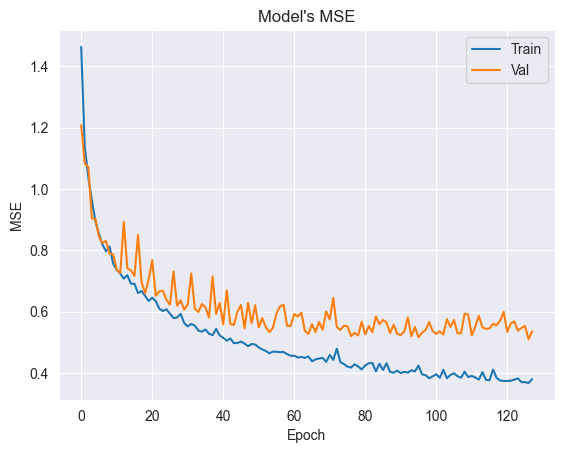

In [22]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's MSE")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('MSE')
plt.xlabel('Epoch')

# Prediction

In [25]:
prediction_word = "jeg er en sur mand"
prediction_word = tokenizer.texts_to_sequences([prediction_word])
prediction_word = pad_sequences(prediction_word, maxlen=input_dim)
prediction = model.predict([prediction_word])
output_probabilities = np.array(prediction)

result = []
class_labels = df.iloc[:, -1].unique()
for index, prediction in enumerate(output_probabilities[0]):
    result.append(f"{class_labels[index]} - {round(prediction*100, 1)}%")

for r in result:
    print(r)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Swedish - 13.7%
Spanish - 0.0%
English - 0.5%
Danish - 0.0%
French - 85.7%
Italian - 0.0%
Norwegian - 0.0%


In [29]:
model.save('./model.keras')